#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. 
4. Проверить данные на тестовой выборке и сделать выводы.

Описание данных:
 - `num_orders` количество заказов

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание признаков</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Lasso" data-toc-modified-id="Lasso-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Lasso</a></span></li><li><span><a href="#ElasticNet" data-toc-modified-id="ElasticNet-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>ElasticNet</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat
import lightgbm as lgb
from prophet import Prophet
!pip install catboost --quiet
import catboost as cb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col = ['datetime'], parse_dates = ['datetime'])

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Прочитали данные, перевели формат даты к datetime и установили дату в качестве индекса.   
Отсортируем таблицу в хронологическом порядке.

In [ ]:
df = df.sort_index()
df.index.is_monotonic

True

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Данные представлены в диапозоне от 1.03.2018 до 31.08.2018 с шагом в 10 минут.  
Пропуски отсутсвуют, тип данных указан верно.  
Поскольку необходимо спрогнозировать количество заказов такси на следующий час, выполним ресеплирование по одному часу.

In [ ]:
df = df.resample('1H').sum()

Таким образом, мы подготовили данные к анализу и построению модели (изменили формат даты, добавили ее в индекс, отсортировали, выполнили ресемплирование по одному часу).

## Анализ

Посмотрим на количество заказов по дням и добавим скользящее среднее (по месяцу).

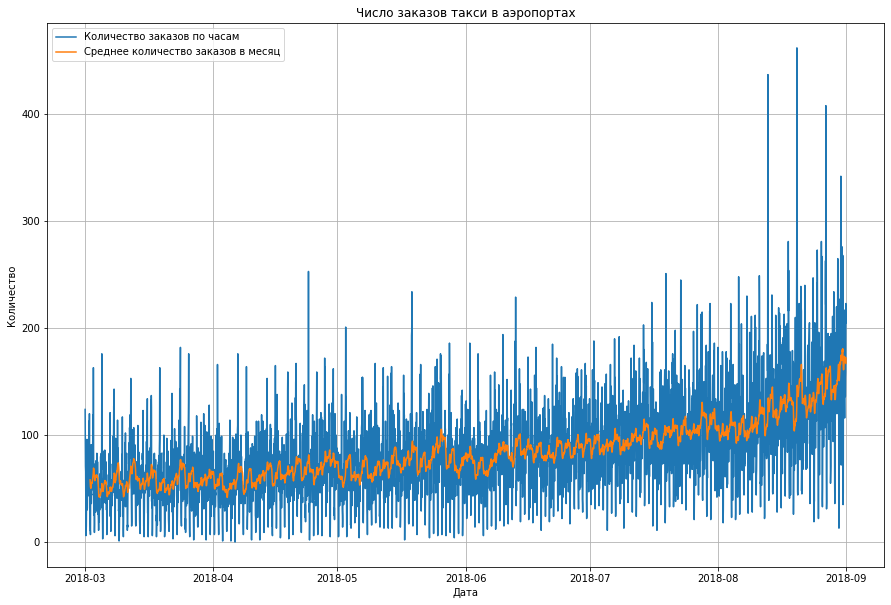

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(df, label="Количество заказов по часам")
plt.plot(df.rolling(30).mean(), label="Среднее количество заказов в месяц")
plt.legend()
plt.title('Число заказов такси в аэропортах')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid(True)

Как видим, количество заказов растет.  
Проверим наличие тренда и сезонности.

In [ ]:
decomposed = seasonal_decompose(df)

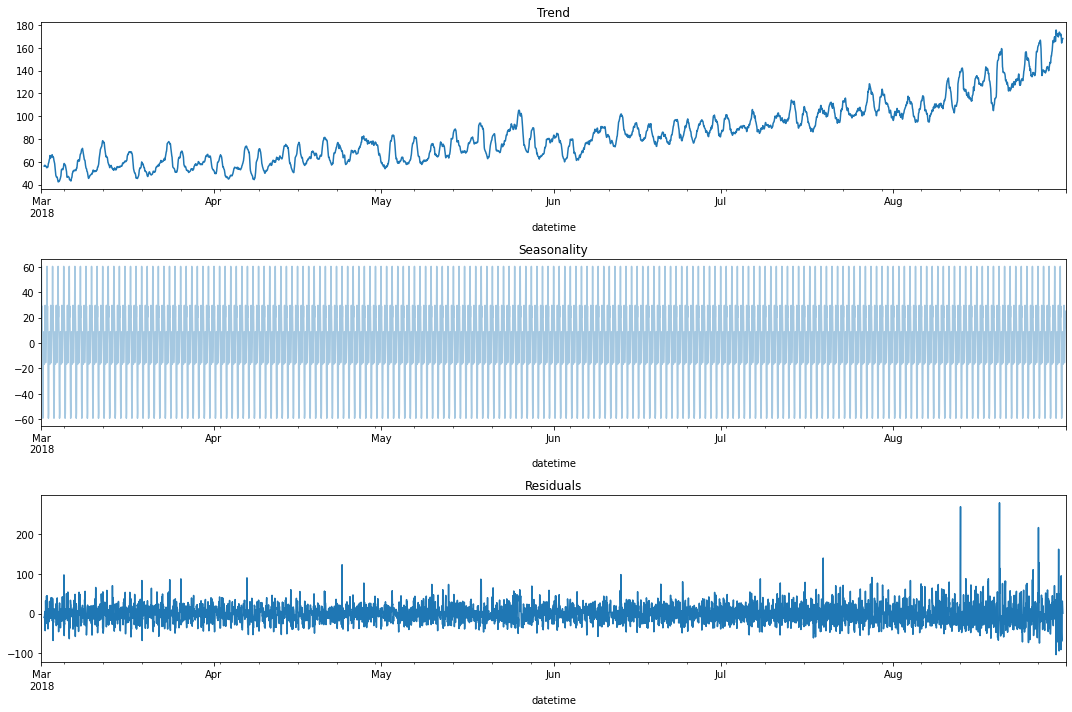

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), alpha=0.4)
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Таким образом, можем заметить, что присутсвует тренд на увеличение количества заказов с марта по сентябрь 2018 г.  
Рассмотрм подробнее сезонность.

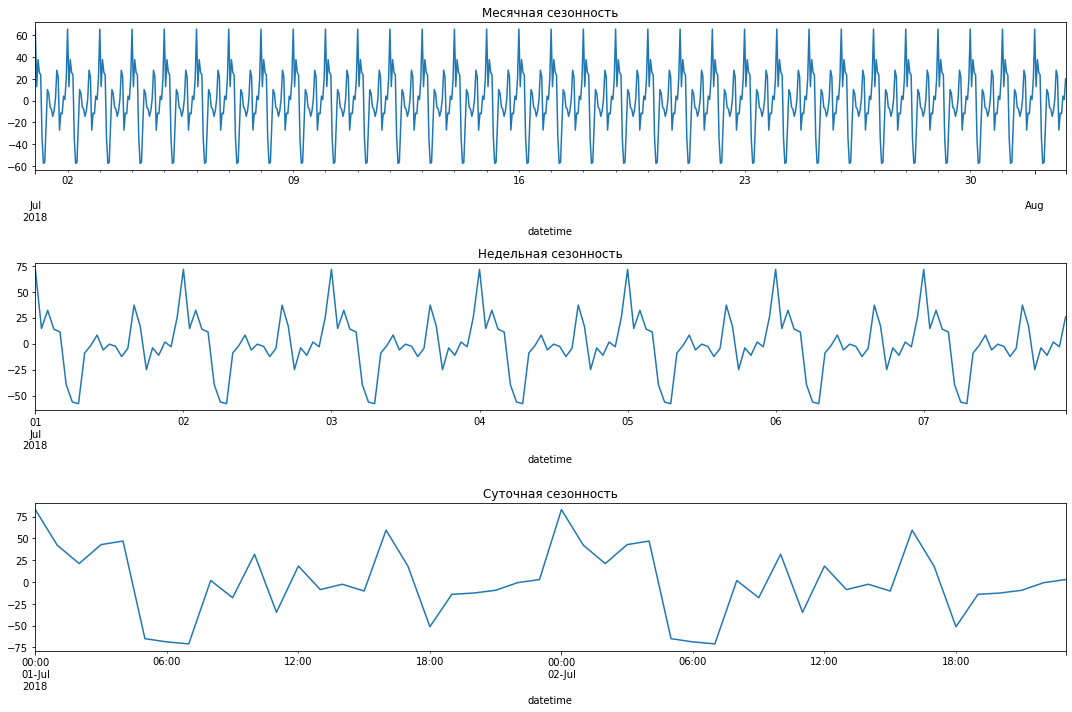

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
seasonal_decompose(df['2018-07-01':'2018-08-01']).seasonal.plot(ax=plt.gca())
plt.title('Месячная сезонность')

plt.subplot(312)
seasonal_decompose(df['2018-07-01':'2018-07-07']).seasonal.plot(ax=plt.gca())
plt.title('Недельная сезонность')

plt.subplot(313)
seasonal_decompose(df['2018-07-01':'2018-07-02']).seasonal.plot(ax=plt.gca())
plt.title('Суточная сезонность')

plt.tight_layout()

В данных присутсвует суточная сезонность.  
Можем заметить, что количество заказов такси достигает пиковых значений ночью, в районе 0 часов, в то время как в период с 5 до 7 устра наименьшее значение заказов такси. Это обусловлено тем, что ночью общественный транспорт из аэропорта либо не ходит, либо ходит крайне редко (зависит от города), что способствует росту заказов такси.

## Обучение

### Создание признаков

Напишем функцию по созданию признаков (день недели, час, остающие значения и скользящее среднее).

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Применим функцию.

In [ ]:
make_features(df, 24, 24)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,133.0,166.0,136.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,164.875000
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,116.0,133.0,166.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,167.541667
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,197.0,116.0,133.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.041667


Разделим исходные данные на обучающую и тестовую выборки в соотношении 9 к 1.

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
train.shape

(3974, 28)

In [ ]:
test.shape

(442, 28)

Удалим пропуски в тестовой выборке.

In [ ]:
train = train.dropna()

Выделим признаки и целевой признак.

In [ ]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

Создадим функцию для добавления результатов работы моделей.

In [ ]:
results = {'name': [], 'best_params':[], 'RMSE':[]}

def add_model_result(results, name, best_params, rmse):
    results['name'].append(name)
    results['best_params'].append(best_params)
    results['RMSE'].append(rmse)

Для оценки качества модели будем использовать TimeSeriesSplit, так как для временного ряда необходимо учитывать хронологии при кросс-валидации.

Перейдем к подбору гиперпараметров для моделей.

### LinearRegression

In [ ]:
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [ ]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 
              'normalize':[True,False], 
              'copy_X':[True, False]}
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efc2a1e1ed0>,
             estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_squared_error')

In [ ]:
print('LinearRegression', (abs(grid.best_score_))**0.5, grid.best_params_)

LinearRegression 26.865382062299556 {'copy_X': True, 'fit_intercept': False, 'normalize': True}


In [ ]:
add_model_result(results, 'LinearRegression', grid.best_params_, (abs(grid.best_score_))**0.5)

### Lasso

In [ ]:
model = Lasso()
parameters = {'alpha':[0.0005,0.0006,0.06,0.5,0.0001,0.01,1,2,3,4,4.4,4]}
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efc2a2536d0>,
             estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0006, 0.06, 0.5, 0.0001, 0.01, 1,
                                   2, 3, 4, 4.4, 4]},
             scoring='neg_mean_squared_error')

In [ ]:
print('Lasso', (abs(grid.best_score_))**0.5, grid.best_params_)

Lasso 26.85465587640938 {'alpha': 4}


In [ ]:
add_model_result(results, 'Lasso', grid.best_params_, (abs(grid.best_score_))**0.5)

### ElasticNet

In [ ]:
model = ElasticNet()
parameters = {'max_iter': [1, 5, 10], 
              'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
              'l1_ratio': np.arange(0.0, 1.0, 0.1)}
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid = GridSearchCV(model, parameters, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efc2a2522d0>,
             estimator=ElasticNet(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'l1_ratio': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1, 5, 10]},
             scoring='neg_mean_squared_error')

In [ ]:
print('ElasticNet', (abs(grid.best_score_))**0.5, grid.best_params_)

ElasticNet 26.851975739889248 {'alpha': 10, 'l1_ratio': 0.4, 'max_iter': 10}


In [ ]:
add_model_result(results, 'ElasticNet', grid.best_params_, (abs(grid.best_score_))**0.5)

### CatBoost

In [ ]:
%%time
model = CatBoostRegressor(silent=True)

parameters = {'depth' : sp_randint(1, 10),
              'learning_rate' : [0.01, 0.02, 0.03, 0.5, 0.6, 0.7],
              'iterations' : sp_randint(10, 400)
             }
tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid = RandomizedSearchCV(model,parameters, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

CPU times: user 6min 14s, sys: 7.59 s, total: 6min 22s
Wall time: 3min 26s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efc2a228a50>,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7efc2580ca10>,
                   param_distributions={'depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efc2580cc10>,
                                        'iterations': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efc2a1f2b90>,
                                        'learning_rate': [0.01, 0.02, 0.03, 0.5,
                                                          0.6, 0.7]},
                   scoring='neg_mean_squared_error')

In [ ]:
print('CatBoost', (abs(grid.best_score_))**0.5, grid.best_params_)

CatBoost 25.071405509557437 {'depth': 3, 'iterations': 351, 'learning_rate': 0.03}


In [ ]:
add_model_result(results, 'CatBoost', grid.best_params_, (abs(grid.best_score_))**0.5)

### LightGBM 

In [ ]:
%%time
model = lgb.LGBMRegressor()
parameters = {'num_leaves' : [20,40,60,80,100],
              'max_depth' : sp_randint(1, 10),
              'reg_alpha':[0,0.01,0.03]}

tscv = TimeSeriesSplit(n_splits=8).split(X_train)
grid = RandomizedSearchCV(model,parameters, scoring='neg_mean_squared_error', cv=tscv)
grid.fit(X_train, y_train)

CPU times: user 17.9 s, sys: 456 ms, total: 18.3 s
Wall time: 9.4 s


RandomizedSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7efc2a252f50>,
                   estimator=LGBMRegressor(),
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7efc54c1a590>,
                                        'num_leaves': [20, 40, 60, 80, 100],
                                        'reg_alpha': [0, 0.01, 0.03]},
                   scoring='neg_mean_squared_error')

In [ ]:
print('LightGBM', (abs(grid.best_score_))**0.5, grid.best_params_)

LightGBM 24.408485521130892 {'max_depth': 4, 'num_leaves': 60, 'reg_alpha': 0}


In [ ]:
add_model_result(results, 'LightGBM', grid.best_params_, (abs(grid.best_score_))**0.5)

### Prophet

Для этой модели подготовим данные и выделим валидационную выборку.

In [ ]:
train_prophet = train['num_orders'].reset_index().copy()
train_prophet.columns = ['ds', 'y']
train_prophet, valid_prophet = train_test_split(train_prophet, shuffle=False, test_size=0.2)

Обучим модель и вычислим RMSE.

In [ ]:
model = Prophet()
model.fit(train_prophet)
forecast = model.predict(pd.DataFrame(valid_prophet['ds']))

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbgc1j070/5aacub58.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbgc1j070/6yfh25yg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60276', 'data', 'file=/tmp/tmpbgc1j070/5aacub58.json', 'init=/tmp/tmpbgc1j070/6yfh25yg.json', 'output', 'file=/tmp/tmpcb3wx0rn/prophet_model-20220828094041.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
(mean_squared_error(valid_prophet['y'], forecast['yhat']))**0.5

32.23223390896504

In [ ]:
add_model_result(results, 'Prophet', '', (mean_squared_error(valid_prophet['y'], forecast['yhat']))**0.5)

### Результаты моделей

In [ ]:
pd.DataFrame(results).sort_values('RMSE')


,name,best_params,RMSE
4,LightGBM,"{'max_depth': 4, 'num_leaves': 60, 'reg_alpha'...",24.408486
3,CatBoost,"{'depth': 3, 'iterations': 351, 'learning_rate...",25.071406
2,ElasticNet,"{'alpha': 10, 'l1_ratio': 0.4, 'max_iter': 10}",26.851976
1,Lasso,{'alpha': 4},26.854656
0,LinearRegression,"{'copy_X': True, 'fit_intercept': False, 'norm...",26.865382
5,Prophet,,32.232234


Таким образом, лучшей моделью является LightGBM с параметрами: `max_depth' = 4, 'num_leaves' = 60, 'reg_alpha' = 0`, показавщая RMSE = 24.4.

## Тестирование

In [ ]:
lgbm = lgb.LGBMRegressor(max_depth = 4, num_leaves = 60, reg_alpha = 0)
lgbm.fit(X_train, y_train)
predictions = lgbm.predict(X_test)
mean_squared_error(y_test, predictions)**0.5

42.02772844003646

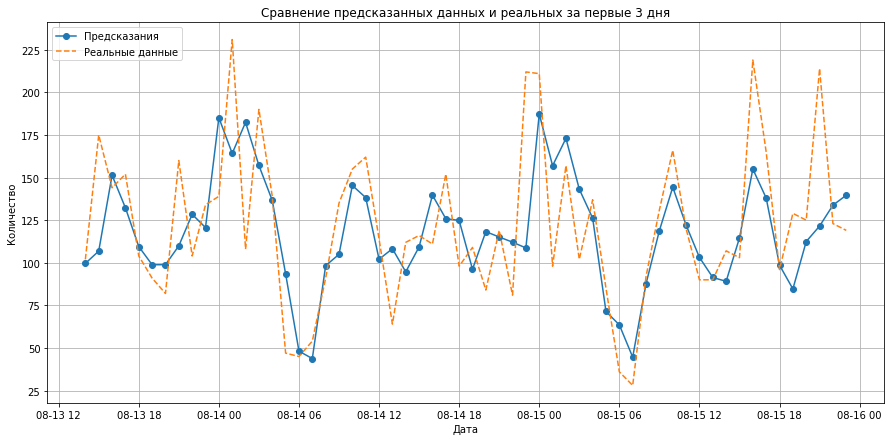

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(pd.Series(predictions, index=y_test.index)['2018-08-13':'2018-08-15'], label="Предсказания", marker='o')
plt.plot(y_test['2018-08-13':'2018-08-15'], label="Реальные данные", linestyle='dashed')
plt.legend()
plt.title('Сравнение предсказанных данных и реальных за первые 3 дня')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.grid(True)

## Вывод

Нами проведен анализ временного ряда, содержащего сведения о количестве заказов такси. Выявлен восходящий тренд на увеличение количество заказов за предоставленный период (с 1.03.2018 до 31.08.2018) и суточная сезонность.  
Подготовленны данные для построения модели, добавлены признаки: день недели, час, остающие значения и скользящее среднее.  
Проверены несколько моделей машинного обучения, выбрана лучшая, которой стало LightGBM с гиперпараметрами: `max_depth' = 4, 'num_leaves' = 60, 'reg_alpha' = 0`, и проверена на тестовой выборке, показав значение RMSE равное 42.03.

Таким образом, цель проекта (спрогнозировать количество заказов такси на следующий час, значение метрики RMSE меньше 48) выполнена.